In [1]:
import glob
import numpy as np
import os
import h5py
import time
import datetime
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm, expon, chi2, uniform
from scipy.stats import chisquare
from scipy.optimize import leastsq, curve_fit, least_squares
import getpass
os.system("echo %s| kinit" %getpass.getpass())

········


0

In [2]:
def BuildSample(N_Sig, N_Bkg, N_ref, INPUT_PATH_BKG, INPUT_PATH_SIG):
    seed=datetime.datetime.now().microsecond+datetime.datetime.now().second+datetime.datetime.now().minute
    np.random.seed(seed)
    feature_name=['Lep1Px', 'lep1Pz', 'Lep1IsoCh', 'Lep1IsoGamma', 'Lep1IsoNeu',
       'Lep1Charge', 'Lep1IsEle', 'Lep2Px', 'Lep2Py', 'Lep2Pz',
       'Lep2IsoCh', 'Lep2IsoGamma', 'Lep2IsoNeu', 'Lep2Charge',
       'Lep2IsEle', 'Jet1Px', 'Jet1Py', 'Jet1Pz', 'Jet1Mass', 'Jet1Btag',
       'Jet2Px', 'Jet2Py', 'Jet2Pz', 'Jet2Mass', 'Jet2BTag', 'HT', 'METx',
       'METy', 'nJets', 'nBjets', 'Mll', 'MT_l1MET', 'MT_l2MET',
       'MT_llMET', 'Mjj', 'Mjjll', 'MT_j1MET', 'MT_j2MET', 'MT_jjMET']
    #random integer to select Zprime file between 0 and 19  
    u = np.random.randint(10, size=20)
    u1 = u[0]
    #random integer to select Zmumu file between 0 and 999
    v = np.random.randint(1000, size=1000)
    v1 = v[0]
    
    #BACKGROUND
    #extract N_ref+N_Bkg events from Zmumu files
    HLF_REF = np.array([])
    HLF_name = ''
    i=0
    for v_i in v:                                                                                                                   
        f = h5py.File(INPUT_PATH_BKG+"Zmumu_13TeV_20PU_"+str(v_i)+".h5")                                                                                                             
        hlf = np.array(f.get('HLF'))
        #print(hlf.shape)
        hlf_names = f.get('HLF_names')
        if not hlf_names:
            continue
        #select the column with px1, pz1, px2, py2, pz2, m12                                                                                       
        cols = [0, 1, 7, 8, 9, 30]
        if i==0:
            HLF_REF=hlf[:, cols]
            i=i+1                                                                                        
        else:
            HLF_REF=np.concatenate((HLF_REF, hlf[:, cols]), axis=0)
        f.close()
        #print(HLF_REF.shape)
        if HLF_REF.shape[0]>=N_ref+N_Bkg:
            HLF_REF=HLF_REF[:N_ref+N_Bkg, :]
            break
    print('HLF_REF+BKG shape')
    print(HLF_REF.shape)

    
    #SIGNAL
    #extract N_Sig events from Zprime files
    toy_label = INPUT_PATH_SIG.split("/")[-2]
    HLF_SIG = np.array([])
    HLF_SIG_name = ''
    i=0                                                                                   
    for u_i in u:
        f = h5py.File(INPUT_PATH_SIG+toy_label+"_"+str(u_i)+".h5")                           
        hlf = np.array(f.get('HLF'))
        hlf_names = f.get('HLF_names')
        if not hlf_names:
            continue
        #select the column with px1, pz1, px2, py2, pz2, m12
        cols=[0, 1, 7, 8, 9, 30]
        if i==0:
            HLF_SIG=hlf[:, cols]
            i=i+1
        else:
            HLF_SIG=np.concatenate((HLF_SIG, hlf[:, cols]), axis=0)
        f.close()
        if HLF_SIG.shape[0]>=N_Sig :
            HLF_SIG=HLF_SIG[:N_Sig, :]
            break
    print('HLF_SIG shape')
    print(HLF_SIG.shape)
    return HLF_REF, HLF_SIG

## Plot input varibales probability distribution

In [3]:
INPUT_PATH_BKG = '/eos/project/d/dshep/BSM_Detection/Zmumu_lepFilter_13TeV/'
INPUT_PATH_SIG = '/eos/project/d/dshep/BSM_Detection/Zprime_lepFilter_300GeV_13TeV/'


output_path='/eos/user/g/ggrosso/BINNED/Zsamples/Theoretical_significance/300GeV/'
if not os.path.exists(output_path):
    os.makedirs(output_path)

Nsig=16000
Nbkg=1600000

HLF_BKG, HLF_SIG = BuildSample(Nsig, Nbkg, 0, INPUT_PATH_BKG, INPUT_PATH_SIG)

HLF_REF+BKG shape
(1600000, 6)
HLF_SIG shape
(16000, 6)


In [4]:
#select the column with px1, pz1, px2, py2, pz2, m12
feature=np.concatenate((HLF_BKG, HLF_SIG), axis=0)

#5D features construction                                                                                                               
p1 = np.sqrt(np.multiply(feature[:, 0], feature[:, 0])+np.multiply(feature[:, 1], feature[:, 1]))
pt1 = feature[:, 0]#+feature[:, 4]
pt2 = np.sqrt(np.multiply(feature[:, 2], feature[:, 2])+np.multiply(feature[:, 3], feature[:, 3]))
p2 = np.sqrt(np.multiply(pt2, pt2)+np.multiply(feature[:, 4], feature[:, 4]))
eta1 = np.arctanh(np.divide(feature[:, 1], p1))
eta2 = np.arctanh(np.divide(feature[:, 4], p2))
phi1 = np.arccos(np.divide(feature[:, 0], pt1))
phi2 = np.sign(feature[:, 3])*np.arccos(np.divide(feature[:, 2], pt2))+np.pi*(1-np.sign(feature[:, 3]))
delta_phi = phi2 - phi1
Zmass = feature[:, 5]
cos_phi1 = np.divide(feature[:, 1], p1)

pt1 = np.expand_dims(pt1, axis=1)
pt2 = np.expand_dims(pt2, axis=1)
eta1 = np.expand_dims(eta1, axis=1)
eta2 = np.expand_dims(eta2, axis=1)
delta_phi = np.expand_dims(delta_phi, axis=1)
Zmass = np.expand_dims(Zmass, axis=1)
cos_phi1 = np.expand_dims(cos_phi1, axis=1)

final_features = np.concatenate((pt1, pt2), axis=1)
final_features = np.concatenate((final_features, eta1), axis=1)
final_features = np.concatenate((final_features, eta2), axis=1)
final_features = np.concatenate((final_features, delta_phi), axis=1)
final_features = np.concatenate((final_features, Zmass), axis=1)
final_features = np.concatenate((final_features, cos_phi1), axis=1)

print('final_features shape ')
print(final_features.shape)

final_BKG = final_features[:Nbkg, :]
final_SIG = final_features[Nbkg:, :]
print(final_SIG.shape)
print(final_BKG.shape)

final_features shape 
(1616000, 7)
(16000, 7)
(1600000, 7)


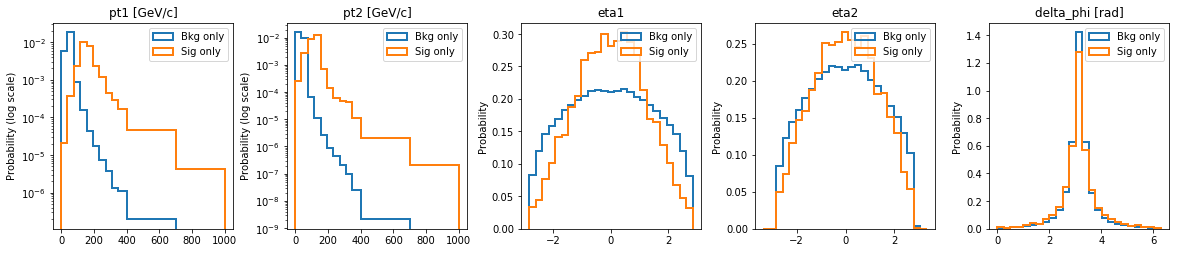

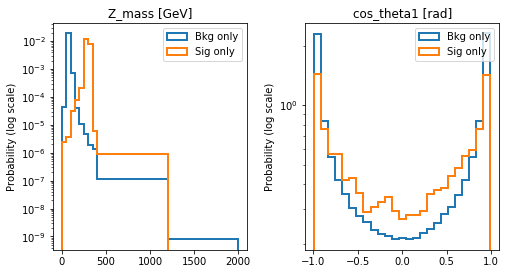

In [19]:
final_variables=['pt1 [GeV/c]', 'pt2 [GeV/c]', 'eta1', 'eta2', 'delta_phi [rad]', 'Z_mass [GeV]', 'cos_theta1 [rad]']
fig=plt.figure(figsize=(20, 10))
for i in range(len(final_variables)-2):
    plt.subplot(2, 5, i+1)
    bins=25
    if i==0 or i==1:
        bins=np.append(np.linspace(0, 350, 10), np.linspace(400, 1000, 3))
    plt.hist(final_BKG[:, i], density=True, range=(np.min(final_features[:, i]), np.max(final_features[:, i])),
             histtype='step', linewidth=2, bins=bins, label='Bkg only')
    plt.hist(final_SIG[:, i], density=True, range=(np.min(final_features[:, i]), np.max(final_features[:, i])),
             histtype='step', linewidth=2, bins=bins, label='Sig only')
    plt.legend()
    plt.ylabel('Probability')
    if i==0 or i==1:
        plt.yscale('log')
        plt.ylabel('Probability (log scale)')
    plt.title(final_variables[i])
plt.subplots_adjust(left=0.125, right=0.9, bottom = 0.25, wspace=0.3, hspace=0.2)
plt.show()
fig.savefig(output_path+'RLF_BvsS_S'+str(Nsig)+'_B'+str(Nbkg)+'.png')
plt.close(fig)

fig=plt.figure(figsize=(8, 5))
plt.subplot(1, 2, 1)
bins=np.append(np.linspace(0, 350, 8), np.linspace(400, 2000, 3))#[500, 600, 700, 800])
plt.hist(final_BKG[:, -2], bins, density=True, range=(np.min(final_features[:, -2]), np.max(final_features[:, -2])),
             histtype='step', linewidth=2, label='Bkg only')
plt.hist(final_SIG[:, -2], bins, density=True, range=(np.min(final_features[:, -2]), np.max(final_features[:, -2])),
             histtype='step', linewidth=2, label='Sig only')
plt.legend()
plt.yscale('log')
plt.ylabel('Probability (log scale)')
plt.title(final_variables[-2])

plt.subplot(1, 2, 2)
plt.hist(final_BKG[:, -1], density=True, range=(np.min(final_features[:, -1]), np.max(final_features[:, -1])),
             histtype='step', linewidth=2, bins=25, label='Bkg only')
plt.hist(final_SIG[:, -1], density=True, range=(np.min(final_features[:, -1]), np.max(final_features[:, -1])),
             histtype='step', linewidth=2, bins=25, label='Sig only')
plt.legend()
plt.yscale('log')
plt.ylabel('Probability (log scale)')
plt.title(final_variables[-1])
#plt.subplots_adjust(left=0.25, right=1., bottom = 0.25, wspace=0.5, hspace=0.3)
plt.subplots_adjust(left=0.125, right=0.9, bottom = 0.25, wspace=0.3, hspace=0.2)
plt.show()
fig.savefig(output_path+'HLF_BvsS_S'+str(Nsig)+'_B'+str(Nbkg)+'.png')

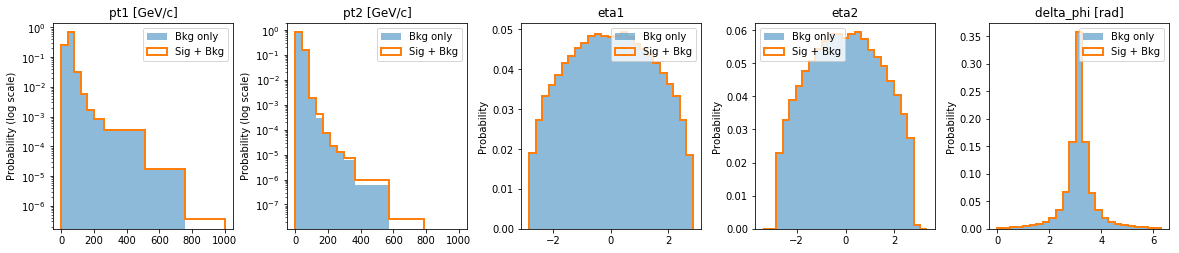

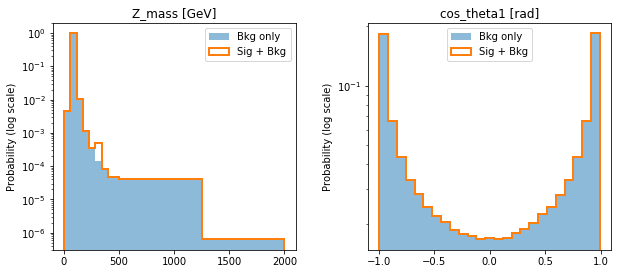

In [9]:
final_variables=['pt1 [GeV/c]', 'pt2 [GeV/c]', 'eta1', 'eta2', 'delta_phi [rad]', 'Z_mass [GeV]', 'cos_theta1 [rad]']
Norm_Sig = 40
Norm_Bkg = 100000

# weights
sig_weights = Norm_Sig*np.ones_like(final_SIG[:, 0])/final_SIG.shape[0] #/ (Norm_Sig+Norm_Bkg) #final_features.shape[0]
bkg_weights = Norm_Bkg*np.ones_like(final_BKG[:, 0])/final_BKG.shape[0] #/ (Norm_Sig+Norm_Bkg) #final_features.shape[0]
merged_weights = np.concatenate((bkg_weights,sig_weights), axis=0) 


fig=plt.figure(figsize=(20, 10))
for i in range(len(final_variables)-2):
    plt.subplot(2, 5, i+1)
    bins=25
    if i==0:
        bins=np.append(np.linspace(0, 200, 6), np.linspace(265, 1000, 4))
    if i==1:
        bins=np.append(np.linspace(0, 300, 8), np.linspace(365, 1000, 4))
    plt.hist(final_BKG[:, i], weights=bkg_weights/Norm_Bkg, range=(np.min(final_features[:, i]), np.max(final_features[:, i])),
             alpha=0.5, bins=bins, label='Bkg only')
    plt.hist(final_features[:, i], weights=merged_weights/(Norm_Sig+Norm_Bkg), range=(np.min(final_features[:, i]), np.max(final_features[:, i])),
             histtype='step', linewidth=2, bins=bins, label='Sig + Bkg')
    plt.ylabel('Probability')
    if i==0 or i==1:
        plt.yscale('log')
        plt.ylabel('Probability (log scale)')
    #plt.hist(sig, density=True)
    #plt.hist(HLF_SIG[:, i], density=True)
    plt.legend()
    plt.title(final_variables[i])
plt.subplots_adjust(left=0.125, right=0.9, bottom = 0.25, wspace=0.3, hspace=0.2)
plt.show()
fig.savefig(output_path+'RLF_BvsTOT_S'+str(Nsig)+'_B'+str(Nbkg)+'.png')
plt.close(fig)

fig=plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
bins=np.append(np.linspace(0, 400, 8), np.linspace(500, 2000, 3))
plt.hist(final_BKG[:, -2], bins, weights=bkg_weights/Norm_Bkg, range=(np.min(final_features[:, -2]), np.max(final_features[:, -2])),
             alpha=0.5, label='Bkg only')
plt.hist(final_features[:, -2], bins, weights=merged_weights/(Norm_Sig+Norm_Bkg), range=(np.min(final_features[:, -2]), np.max(final_features[:, -2])),
             histtype='step', linewidth=2, label='Sig + Bkg')
plt.legend()
plt.ylabel('Probability (log scale)')
plt.title(final_variables[-2])
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(final_BKG[:, -1], weights=bkg_weights/Norm_Bkg, range=(np.min(final_features[:, -1]), np.max(final_features[:, -1])),
             alpha=0.5, bins=25, label='Bkg only')
plt.hist(final_features[:, -1], weights=merged_weights/(Norm_Sig+Norm_Bkg), range=(np.min(final_features[:, -1]), np.max(final_features[:, -1])),
             histtype='step', linewidth=2, bins=25, label='Sig + Bkg')
plt.legend()
plt.ylabel('Probability (log scale)')
plt.title(final_variables[-1])
plt.yscale('log')
plt.subplots_adjust(left=0.125, right=0.9, bottom = 0.25, wspace=0.3, hspace=0.2)
plt.show()
fig.savefig(output_path+'HLF_BvsTOT_S'+str(Nsig)+'_B'+str(Nbkg)+'.png')

# Significance

In [66]:
def Significance(HLF_BKG, HLF_SIG, N_Sig, N_Bkg, Zprime_mass, toy_label, save=0):
    #select the invariant mass (5-th column of HLF)
    sig=HLF_SIG[:N_Sig, 5]
    ref=HLF_BKG[:N_Bkg, 5]
    upper_limit=np.max(np.concatenate((sig, ref), axis=0))
    fig = plt.figure()
    h_sig=plt.hist(sig, bins=int(upper_limit/10), density=False,
                   alpha=0.5, range=(0, upper_limit), label='Z prime (Sig)')#Zprime_mass+100#(Zprime_mass+100)/10
    h_bkg=plt.hist(ref, bins=int(upper_limit/10), density=False,
                   alpha=0.5, range=(0, upper_limit), label='Z0 (Bkg)')#weights=target[target!=1],
    #if density:
    #    plt.ylabel('Probability')
    #else:
    #    plt.ylabel('Counts')
    plt.xlabel('M(Z)')
    plt.title('N(sig)= '+str(N_Sig)+', N(Bkg)= '+str(N_Bkg))
    #plt.xlim(Zprime_mass-100, Zprime_mass+100)
    plt.yscale('log')
    plt.show()
    if save:
        fig.savefig(output_path+str(Zprime_mass)+'GeV_Nsign'+str(N_Sig)+'_Nbkg'+str(N_Bkg)+'_toy'+str(toy_label)+'.png')
    plt.close(fig)
    print('Figure saved')
    
    #count S and B for the significance in a chosen range around the Zprime peack
    sumBkg=0
    sumSig=0
    print('bin range ['+str(Zprime_mass-50)+'-'+str(Zprime_mass+50)+'] GeV')
    print("Nsig \t Nbkg")
    Zprime_bins_range=np.arange(Zprime_mass/10-5, Zprime_mass/10+5)
    for i in Zprime_bins_range:
        l_sig = h_sig[0]
        l_bkg = h_bkg[0]
        x = h_sig[1]
        norm=1
        #if density:
        #    norm=(x[i+1]-x[i])
        #    print(norm)
        print(l_sig[i], l_bkg[i])
        sumSig=sumSig+l_sig[i]#*norm*N_Sig
        sumBkg=sumBkg+l_bkg[i]#*norm*N_Bkg
    print ("N total signals: ")
    print (sumSig)
    print("N total backgrounds: ")
    print (sumBkg)
    #significance=sumSig/np.sqrt(sumSig+sumBkg)
    #print(significance)
    #return significance
    return sumBkg, sumSig

HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


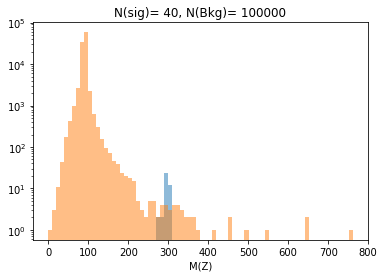

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 5.0)
(2.0, 2.0)
(2.0, 4.0)
(24.0, 4.0)
(12.0, 3.0)
(0.0, 4.0)
(0.0, 4.0)
(0.0, 3.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
36.0
6.666666666666667
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


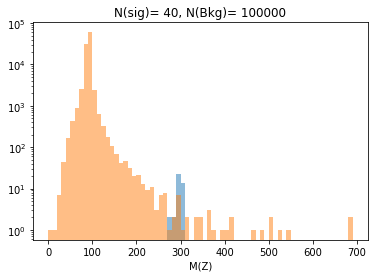

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 8.0)
(2.0, 1.0)
(2.0, 2.0)
(22.0, 7.0)
(14.0, 1.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
32.0
7.071067811865475
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


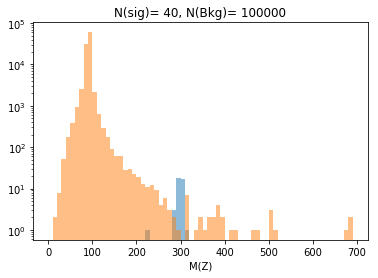

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 6.0)
(0.0, 3.0)
(3.0, 2.0)
(18.0, 1.0)
(17.0, 0.0)
(1.0, 7.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
26.0
7.648529270389178
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


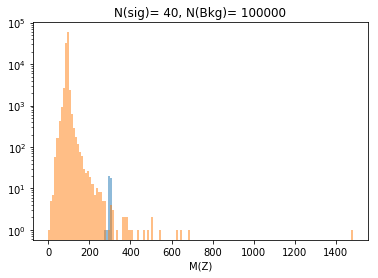

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 8.0)
(0.0, 5.0)
(1.0, 5.0)
(1.0, 0.0)
(20.0, 1.0)
(18.0, 4.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
27.0
7.69800358919501
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


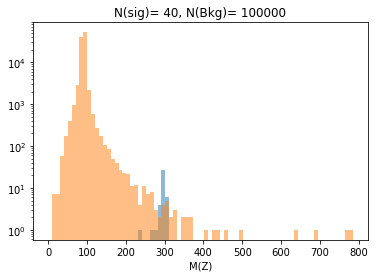

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(1.0, 8.0)
(1.0, 3.0)
(4.0, 2.0)
(27.0, 4.0)
(6.0, 5.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
36.0
6.5
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


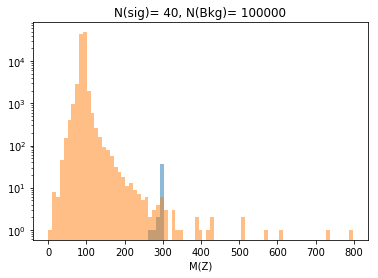

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(1.0, 2.0)
(1.0, 3.0)
(2.0, 4.0)
(36.0, 6.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
29.0
7.427813527082075
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


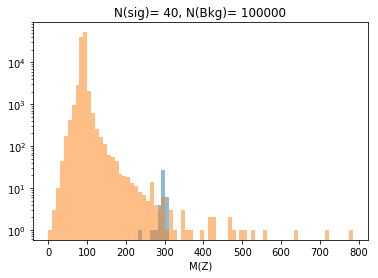

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(1.0, 14.0)
(1.0, 4.0)
(4.0, 3.0)
(27.0, 6.0)
(6.0, 1.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
40.0
6.16644143732834
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


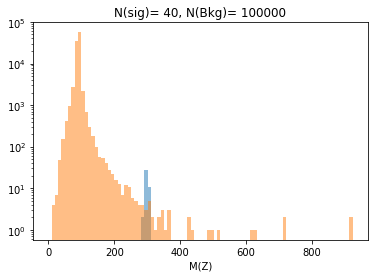

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 5.0)
(0.0, 4.0)
(2.0, 4.0)
(27.0, 3.0)
(11.0, 5.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
35.0
6.761234037828133
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


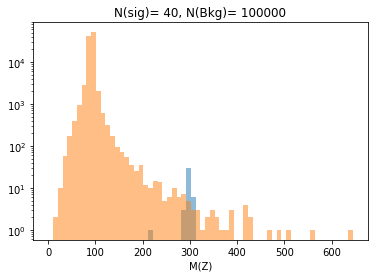

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 10.0)
(0.0, 6.0)
(3.0, 7.0)
(30.0, 5.0)
(6.0, 3.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
46.0
5.750236290040988
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


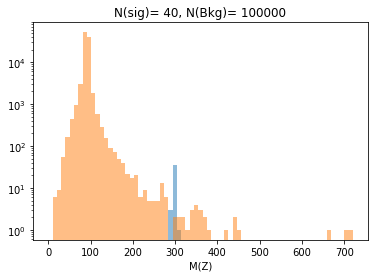

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 13.0)
(0.0, 6.0)
(3.0, 0.0)
(36.0, 2.0)
(1.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 4.0)
N total signals: 
40.0
N total backgrounds: 
38.0
6.488856845230502
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


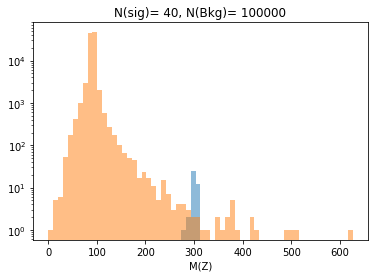

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 4.0)
(1.0, 4.0)
(2.0, 3.0)
(25.0, 2.0)
(12.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
22.0
8.528028654224418
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


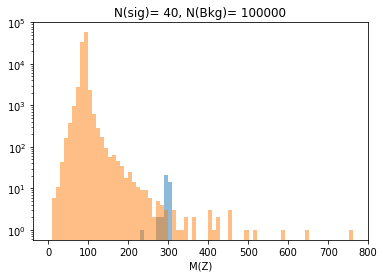

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 2.0)
(2.0, 5.0)
(2.0, 4.0)
(21.0, 3.0)
(14.0, 0.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
27.0
7.505553499465135
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


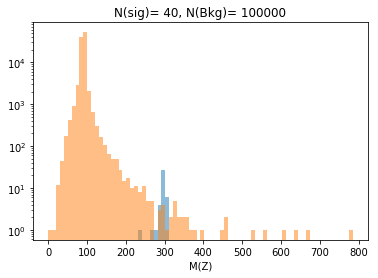

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(1.0, 5.0)
(1.0, 0.0)
(4.0, 3.0)
(27.0, 4.0)
(6.0, 1.0)
(0.0, 2.0)
(0.0, 5.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
29.0
7.242118188905023
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


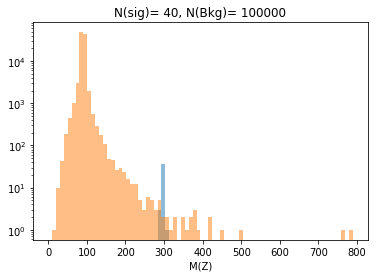

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 5.0)
(0.0, 3.0)
(3.0, 5.0)
(36.0, 2.0)
(1.0, 2.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


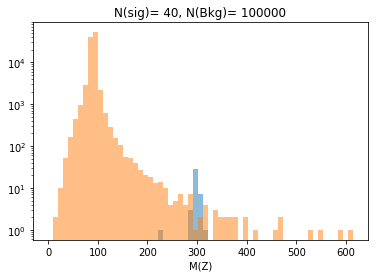

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 7.0)
(0.0, 4.0)
(3.0, 7.0)
(28.0, 1.0)
(7.0, 2.0)
(1.0, 4.0)
(0.0, 0.0)
(0.0, 3.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
35.0
6.592203186882429
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


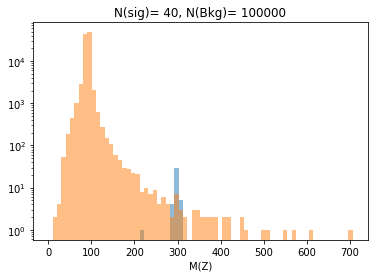

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 6.0)
(0.0, 4.0)
(4.0, 2.0)
(30.0, 7.0)
(5.0, 3.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 3.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
34.0
6.688444820557844
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


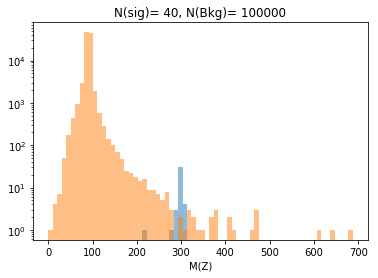

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 8.0)
(1.0, 3.0)
(3.0, 0.0)
(31.0, 2.0)
(4.0, 1.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
26.0
7.648529270389178
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


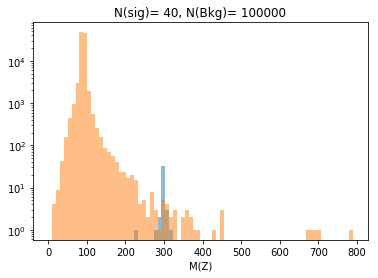

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 8.0)
(1.0, 3.0)
(2.0, 1.0)
(32.0, 5.0)
(3.0, 4.0)
(1.0, 2.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
30.0
7.12039324756716
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


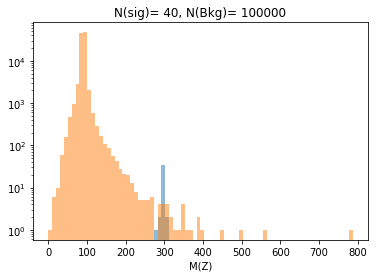

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 6.0)
(1.0, 0.0)
(2.0, 4.0)
(35.0, 4.0)
(2.0, 4.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 4.0)
N total signals: 
40.0
N total backgrounds: 
31.0
7.184212081070997
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


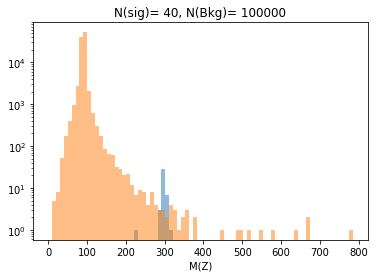

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 8.0)
(0.0, 4.0)
(3.0, 3.0)
(28.0, 3.0)
(7.0, 2.0)
(1.0, 4.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
34.0
6.688444820557844
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


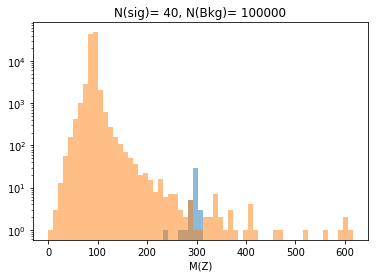

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(1.0, 3.0)
(1.0, 2.0)
(5.0, 5.0)
(29.0, 1.0)
(3.0, 1.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 7.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
32.0
6.894291116568838
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


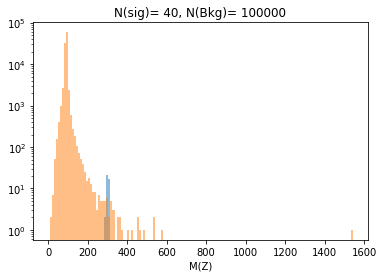

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 5.0)
(0.0, 5.0)
(2.0, 5.0)
(21.0, 6.0)
(17.0, 2.0)
(0.0, 5.0)
(0.0, 3.0)
(0.0, 3.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
41.0
6.246950475544243
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


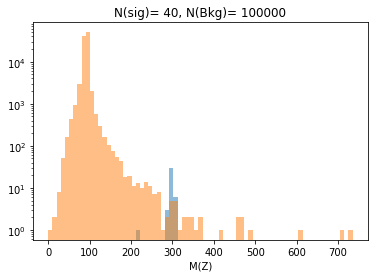

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 8.0)
(0.0, 1.0)
(3.0, 2.0)
(30.0, 5.0)
(6.0, 5.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
35.0
6.592203186882429
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


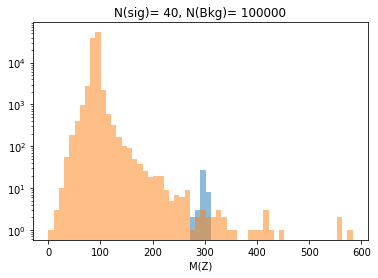

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 9.0)
(2.0, 1.0)
(3.0, 2.0)
(27.0, 3.0)
(8.0, 2.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
31.0
7.184212081070997
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


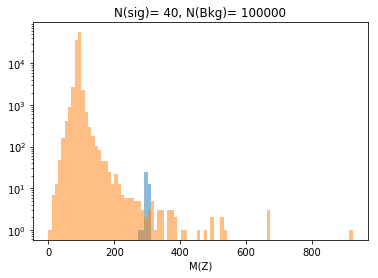

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 5.0)
(1.0, 5.0)
(1.0, 3.0)
(25.0, 2.0)
(13.0, 3.0)
(0.0, 5.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
36.0
6.666666666666667
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


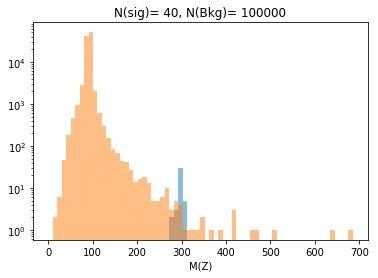

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 10.0)
(2.0, 3.0)
(3.0, 5.0)
(30.0, 4.0)
(5.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
34.0
6.859943405700353
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


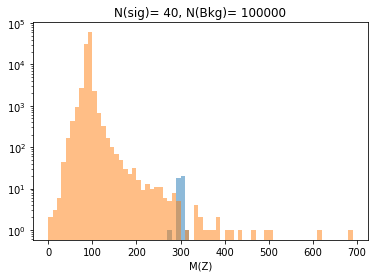

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 11.0)
(0.0, 6.0)
(1.0, 5.0)
(0.0, 8.0)
(18.0, 5.0)
(20.0, 0.0)
(1.0, 1.0)
(0.0, 0.0)
(0.0, 4.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
42.0
6.172133998483676
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


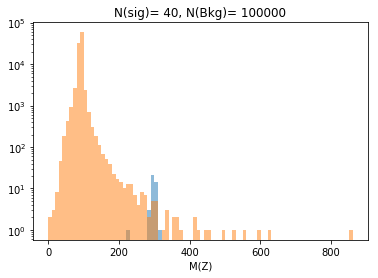

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 8.0)
(0.0, 7.0)
(3.0, 2.0)
(21.0, 5.0)
(14.0, 5.0)
(1.0, 0.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 0.0)
N total signals: 
39.0
N total backgrounds: 
35.0
6.592203186882429
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


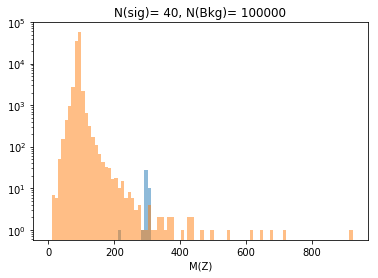

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 3.0)
(0.0, 4.0)
(1.0, 1.0)
(28.0, 1.0)
(10.0, 4.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
25.0
7.8
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


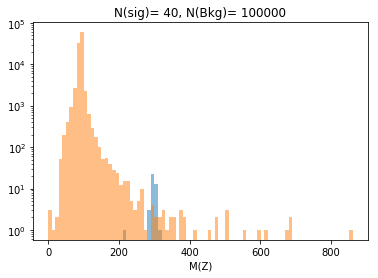

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 10.0)
(0.0, 1.0)
(3.0, 0.0)
(22.0, 4.0)
(13.0, 2.0)
(1.0, 2.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
30.0
7.12039324756716
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


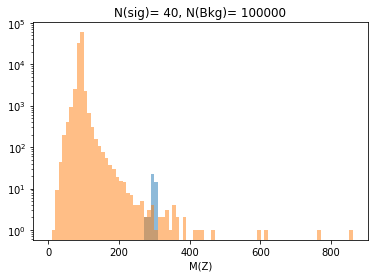

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 5.0)
(2.0, 2.0)
(2.0, 3.0)
(22.0, 4.0)
(14.0, 1.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
27.0
7.69800358919501
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


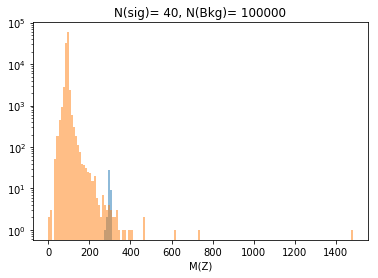

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 7.0)
(1.0, 4.0)
(2.0, 3.0)
(28.0, 4.0)
(9.0, 3.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
31.0
7.184212081070997
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


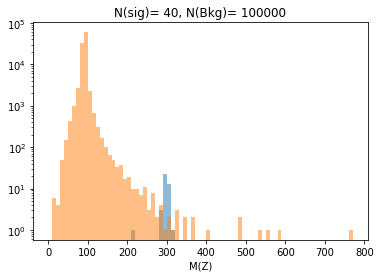

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 8.0)
(0.0, 2.0)
(3.0, 4.0)
(22.0, 1.0)
(13.0, 2.0)
(1.0, 1.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
26.0
7.648529270389178
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


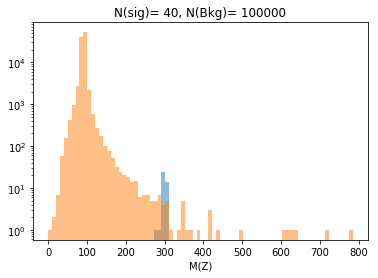

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 5.0)
(1.0, 5.0)
(1.0, 7.0)
(24.0, 4.0)
(14.0, 5.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 5.0)
N total signals: 
40.0
N total backgrounds: 
40.0
6.324555320336758
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


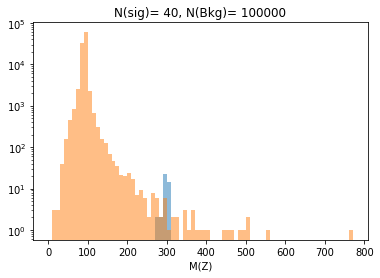

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 8.0)
(2.0, 6.0)
(2.0, 2.0)
(22.0, 6.0)
(14.0, 1.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
32.0
7.071067811865475
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


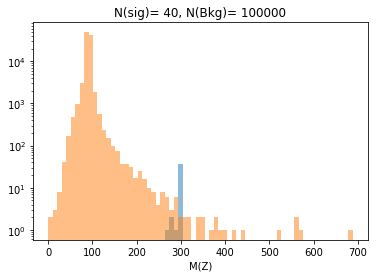

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 8.0)
(1.0, 6.0)
(2.0, 3.0)
(1.0, 6.0)
(36.0, 2.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
33.0
6.963106238227914
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


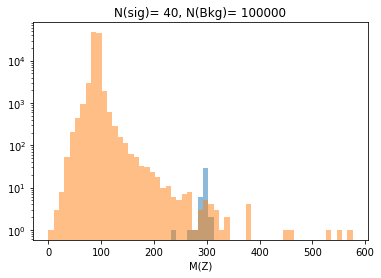

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(1.0, 8.0)
(1.0, 1.0)
(6.0, 3.0)
(29.0, 5.0)
(2.0, 4.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 0.0)
N total signals: 
39.0
N total backgrounds: 
34.0
6.688444820557844
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


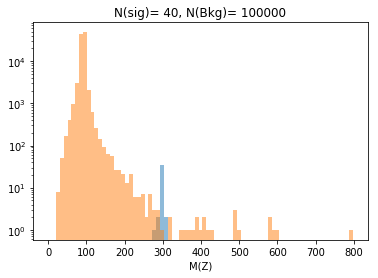

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 7.0)
(1.0, 3.0)
(2.0, 3.0)
(35.0, 1.0)
(2.0, 0.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
19.0
9.17662935482247
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


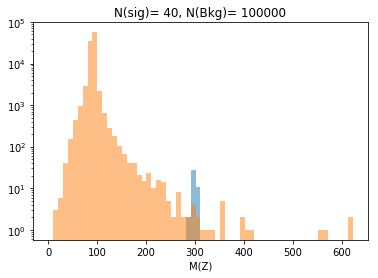

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 8.0)
(0.0, 2.0)
(2.0, 2.0)
(27.0, 4.0)
(11.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
23.0
8.34057656228299
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


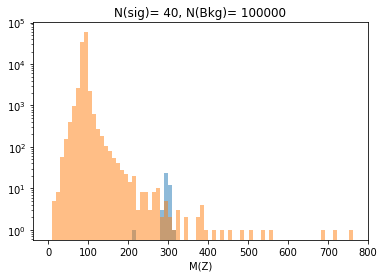

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 8.0)
(0.0, 10.0)
(3.0, 2.0)
(23.0, 5.0)
(12.0, 2.0)
(1.0, 1.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
36.0
6.5
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


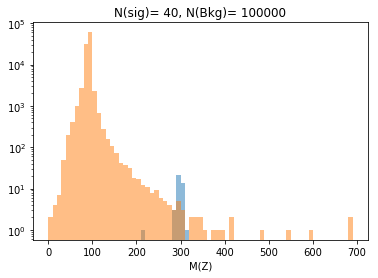

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 5.0)
(0.0, 4.0)
(3.0, 3.0)
(21.0, 5.0)
(14.0, 3.0)
(1.0, 0.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
32.0
6.894291116568838
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


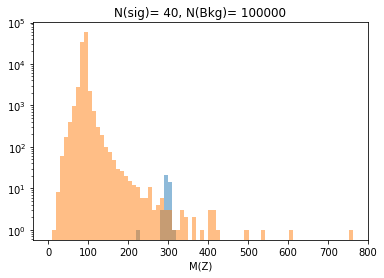

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 11.0)
(0.0, 3.0)
(0.0, 4.0)
(3.0, 6.0)
(21.0, 3.0)
(14.0, 3.0)
(1.0, 1.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
37.0
6.411560504908935
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


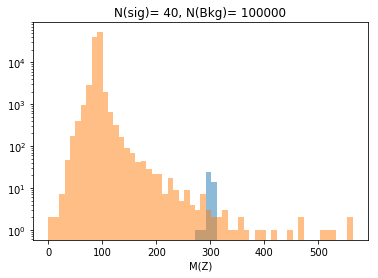

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 9.0)
(0.0, 4.0)
(1.0, 3.0)
(1.0, 7.0)
(24.0, 3.0)
(14.0, 2.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
35.0
6.761234037828133
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


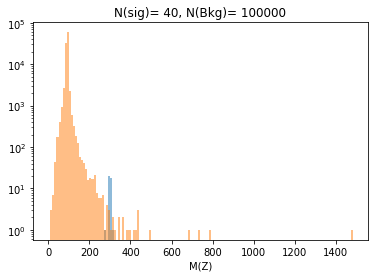

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 7.0)
(1.0, 1.0)
(0.0, 4.0)
(20.0, 3.0)
(18.0, 1.0)
(1.0, 2.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
27.0
7.69800358919501
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


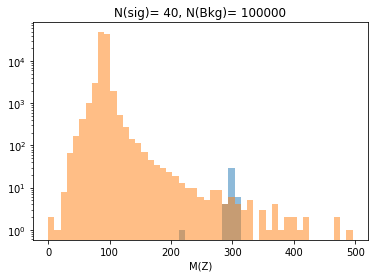

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 9.0)
(0.0, 9.0)
(4.0, 4.0)
(29.0, 6.0)
(6.0, 4.0)
(0.0, 3.0)
(0.0, 5.0)
(0.0, 0.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
48.0
5.629165124598852
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


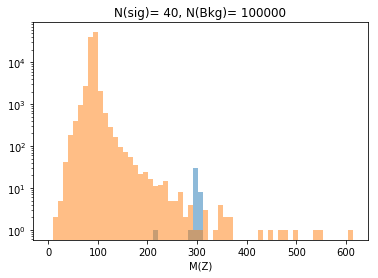

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 8.0)
(0.0, 2.0)
(1.0, 4.0)
(30.0, 1.0)
(8.0, 1.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 4.0)
N total signals: 
39.0
N total backgrounds: 
29.0
7.242118188905023
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


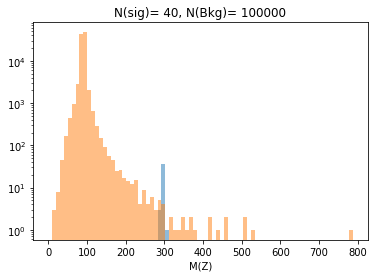

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 6.0)
(0.0, 3.0)
(3.0, 5.0)
(36.0, 4.0)
(1.0, 0.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


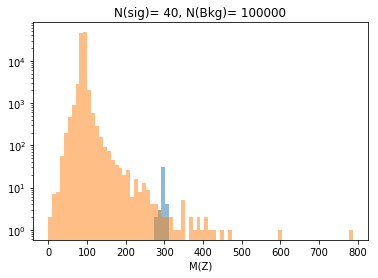

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 9.0)
(0.0, 4.0)
(2.0, 4.0)
(3.0, 3.0)
(31.0, 2.0)
(4.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 5.0)
N total signals: 
40.0
N total backgrounds: 
33.0
6.963106238227914
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


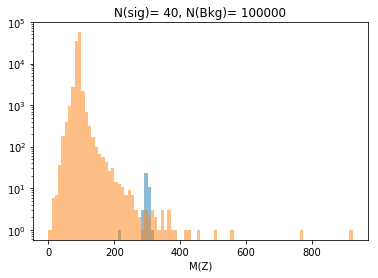

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 3.0)
(0.0, 2.0)
(3.0, 1.0)
(24.0, 3.0)
(11.0, 2.0)
(1.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
27.0
7.505553499465135
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


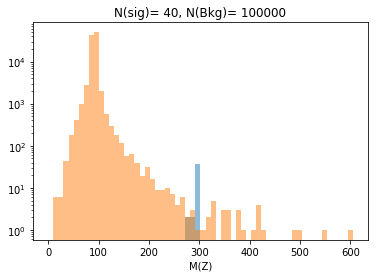

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 6.0)
(2.0, 2.0)
(2.0, 3.0)
(36.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 5.0)
(0.0, 0.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
27.0
7.69800358919501
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


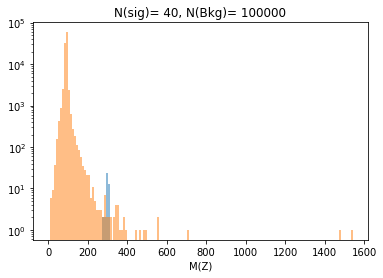

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 3.0)
(2.0, 2.0)
(2.0, 7.0)
(23.0, 2.0)
(13.0, 2.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 4.0)
N total signals: 
40.0
N total backgrounds: 
27.0
7.69800358919501
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


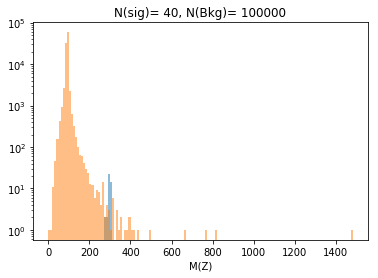

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 14.0)
(2.0, 2.0)
(2.0, 4.0)
(22.0, 3.0)
(14.0, 1.0)
(0.0, 6.0)
(0.0, 0.0)
(0.0, 3.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
38.0
6.488856845230502
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


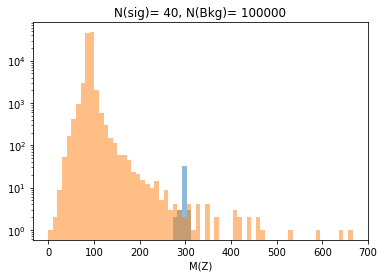

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 9.0)
(0.0, 3.0)
(2.0, 4.0)
(3.0, 3.0)
(32.0, 2.0)
(3.0, 4.0)
(0.0, 1.0)
(0.0, 4.0)
(0.0, 0.0)
(0.0, 4.0)
N total signals: 
40.0
N total backgrounds: 
34.0
6.859943405700353
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


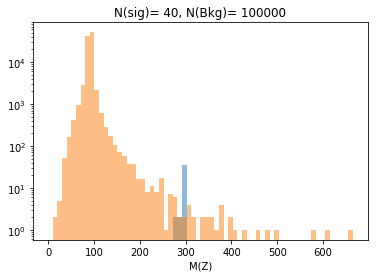

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 1.0)
(0.0, 7.0)
(2.0, 6.0)
(2.0, 2.0)
(36.0, 2.0)
(0.0, 4.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


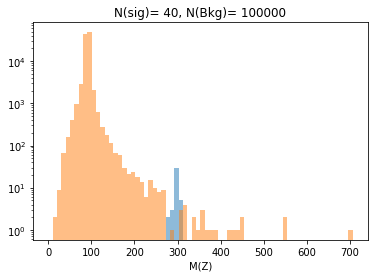

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 8.0)
(0.0, 9.0)
(2.0, 0.0)
(3.0, 1.0)
(30.0, 0.0)
(5.0, 3.0)
(0.0, 4.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


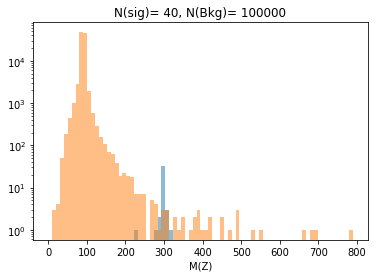

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 0.0)
(0.0, 5.0)
(1.0, 4.0)
(2.0, 1.0)
(32.0, 3.0)
(3.0, 3.0)
(1.0, 0.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
21.0
8.510497719203704
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


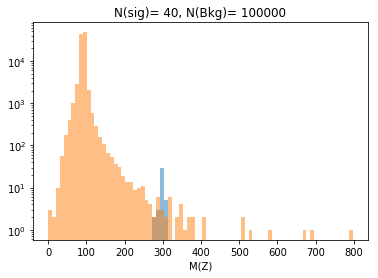

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 4.0)
(2.0, 2.0)
(3.0, 6.0)
(30.0, 3.0)
(5.0, 2.0)
(0.0, 6.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 4.0)
N total signals: 
40.0
N total backgrounds: 
34.0
6.859943405700353
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


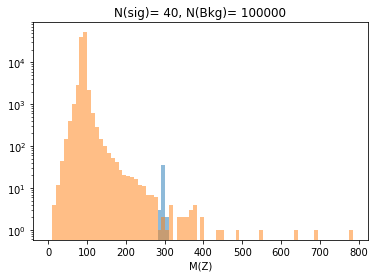

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 7.0)
(0.0, 6.0)
(3.0, 1.0)
(35.0, 2.0)
(2.0, 1.0)
(0.0, 4.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
32.0
7.071067811865475
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


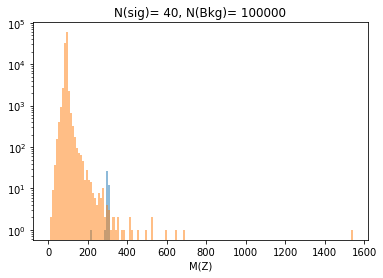

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 8.0)
(0.0, 6.0)
(0.0, 10.0)
(1.0, 2.0)
(26.0, 4.0)
(12.0, 3.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
39.0
6.244997998398398
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


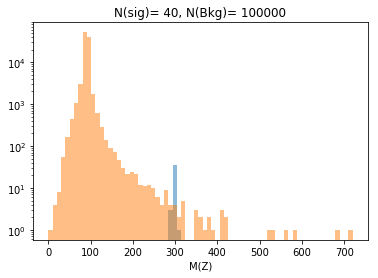

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 4.0)
(0.0, 9.0)
(3.0, 4.0)
(36.0, 4.0)
(1.0, 2.0)
(0.0, 5.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
37.0
6.575959492214292
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


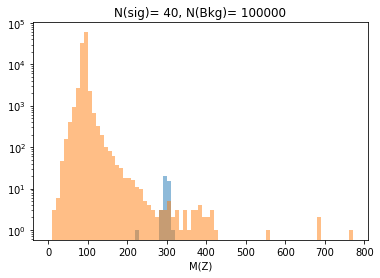

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 3.0)
(0.0, 2.0)
(3.0, 3.0)
(20.0, 3.0)
(15.0, 5.0)
(1.0, 2.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
29.0
7.242118188905023
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


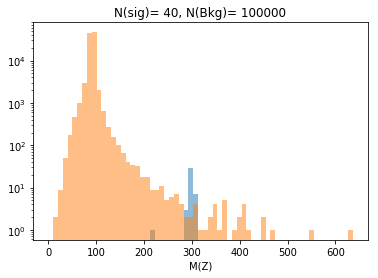

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 7.0)
(0.0, 4.0)
(3.0, 2.0)
(29.0, 2.0)
(7.0, 4.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 4.0)
N total signals: 
39.0
N total backgrounds: 
33.0
6.789028582272215
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


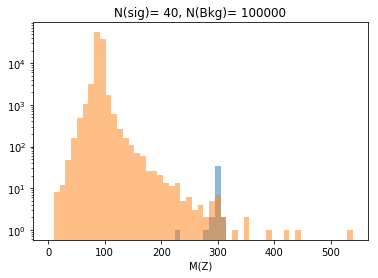

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 4.0)
(1.0, 2.0)
(2.0, 5.0)
(34.0, 7.0)
(2.0, 2.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
26.0
7.648529270389178
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


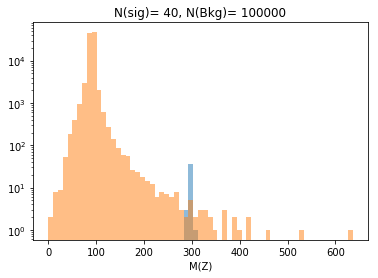

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 8.0)
(0.0, 3.0)
(3.0, 2.0)
(36.0, 5.0)
(1.0, 2.0)
(0.0, 3.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
35.0
6.761234037828133
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


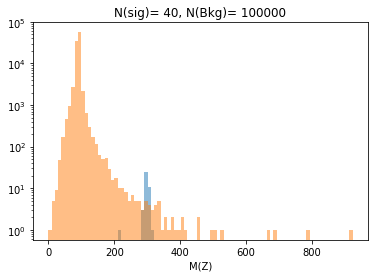

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 5.0)
(0.0, 5.0)
(3.0, 3.0)
(24.0, 5.0)
(11.0, 4.0)
(1.0, 3.0)
(0.0, 4.0)
(0.0, 5.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
42.0
6.017830648521584
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


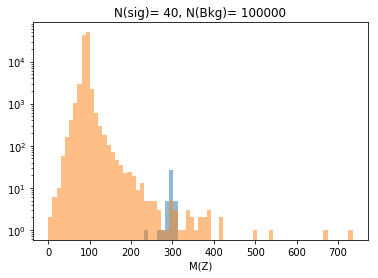

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(1.0, 3.0)
(1.0, 1.0)
(5.0, 1.0)
(27.0, 5.0)
(5.0, 3.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
25.0
7.8
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


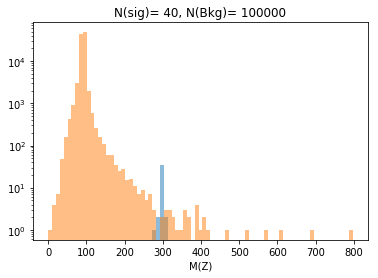

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 7.0)
(1.0, 3.0)
(2.0, 0.0)
(35.0, 2.0)
(2.0, 3.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
27.0
7.69800358919501
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


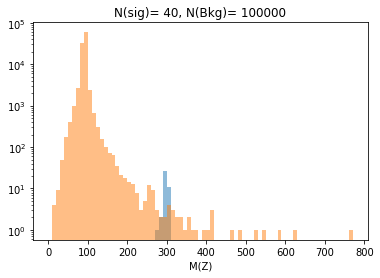

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 12.0)
(0.0, 9.0)
(1.0, 3.0)
(2.0, 2.0)
(26.0, 2.0)
(11.0, 4.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
40.0
6.324555320336758
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


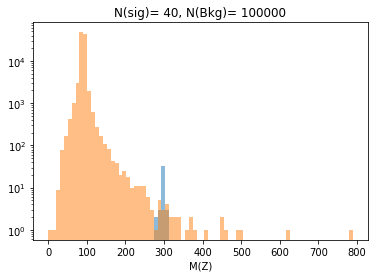

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 3.0)
(2.0, 1.0)
(3.0, 5.0)
(32.0, 3.0)
(3.0, 4.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


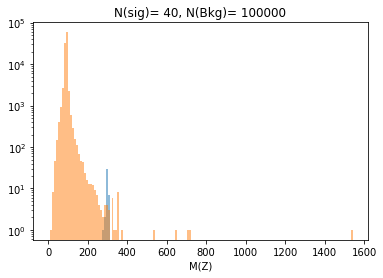

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 3.0)
(1.0, 2.0)
(2.0, 4.0)
(30.0, 4.0)
(7.0, 3.0)
(0.0, 0.0)
(0.0, 6.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


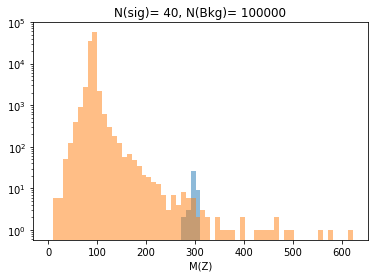

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 4.0)
(2.0, 8.0)
(3.0, 6.0)
(26.0, 6.0)
(9.0, 2.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
40.0
6.324555320336758
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


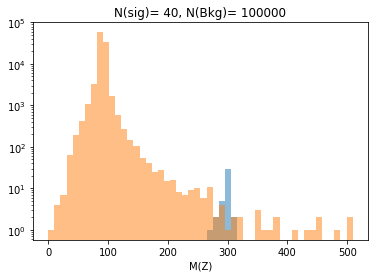

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(1.0, 11.0)
(2.0, 2.0)
(5.0, 4.0)
(30.0, 1.0)
(2.0, 2.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
31.0
7.184212081070997
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


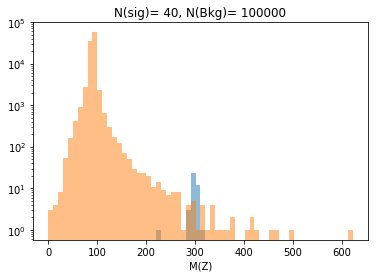

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 8.0)
(0.0, 8.0)
(0.0, 1.0)
(3.0, 4.0)
(23.0, 5.0)
(12.0, 1.0)
(1.0, 4.0)
(0.0, 1.0)
(0.0, 4.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
37.0
6.411560504908935
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


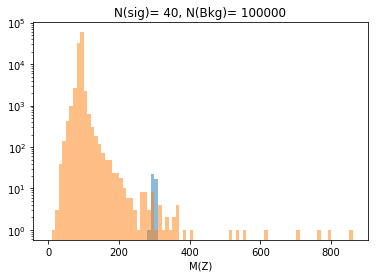

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 1.0)
(0.0, 8.0)
(0.0, 8.0)
(1.0, 3.0)
(22.0, 8.0)
(17.0, 1.0)
(0.0, 4.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
37.0
6.575959492214292
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


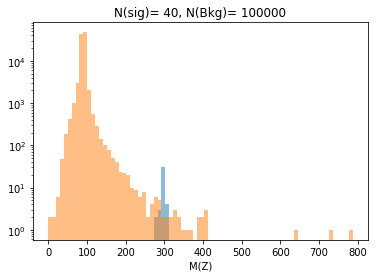

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 4.0)
(2.0, 6.0)
(3.0, 5.0)
(31.0, 2.0)
(4.0, 2.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
29.0
7.427813527082075
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


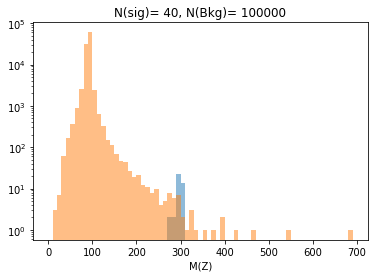

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 5.0)
(2.0, 8.0)
(2.0, 6.0)
(22.0, 7.0)
(14.0, 2.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
37.0
6.575959492214292
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


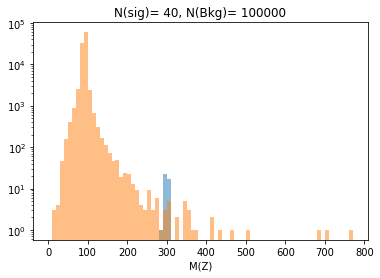

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 9.0)
(0.0, 3.0)
(0.0, 6.0)
(1.0, 1.0)
(22.0, 3.0)
(17.0, 5.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 0.0)
(0.0, 5.0)
N total signals: 
40.0
N total backgrounds: 
34.0
6.859943405700353
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


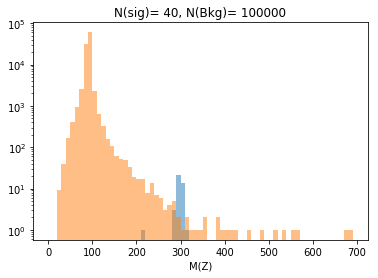

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 3.0)
(0.0, 4.0)
(3.0, 5.0)
(21.0, 2.0)
(14.0, 1.0)
(1.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
26.0
7.648529270389178
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


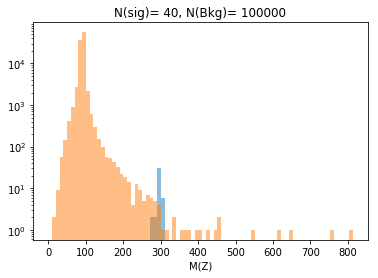

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 7.0)
(2.0, 6.0)
(2.0, 5.0)
(30.0, 4.0)
(6.0, 1.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
31.0
7.184212081070997
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


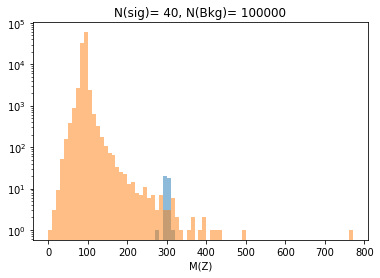

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 7.0)
(1.0, 3.0)
(0.0, 7.0)
(20.0, 3.0)
(18.0, 3.0)
(1.0, 6.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
38.0
6.488856845230502
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


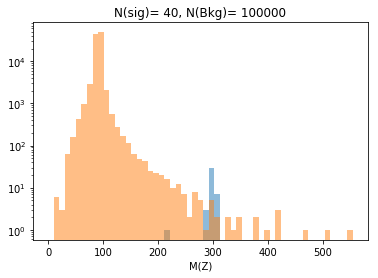

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 2.0)
(0.0, 8.0)
(0.0, 5.0)
(3.0, 1.0)
(29.0, 5.0)
(7.0, 2.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
28.0
7.370307223679931
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


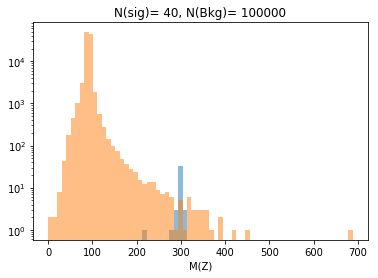

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 8.0)
(1.0, 6.0)
(3.0, 1.0)
(32.0, 5.0)
(3.0, 1.0)
(0.0, 6.0)
(0.0, 3.0)
(0.0, 3.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
43.0
5.947444242971582
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


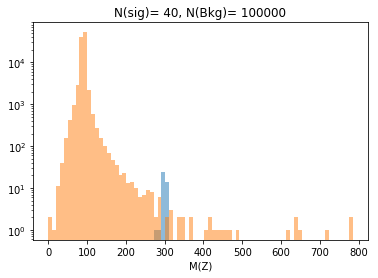

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 9.0)
(0.0, 8.0)
(1.0, 2.0)
(1.0, 6.0)
(24.0, 0.0)
(14.0, 2.0)
(0.0, 3.0)
(0.0, 0.0)
(0.0, 2.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
34.0
6.859943405700353
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


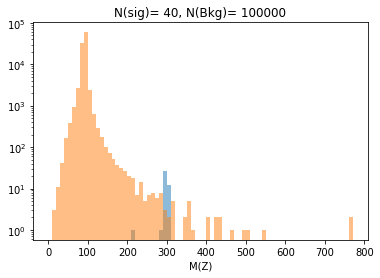

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 8.0)
(0.0, 6.0)
(1.0, 8.0)
(26.0, 3.0)
(12.0, 2.0)
(0.0, 5.0)
(0.0, 0.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
41.0
6.090776713655637
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


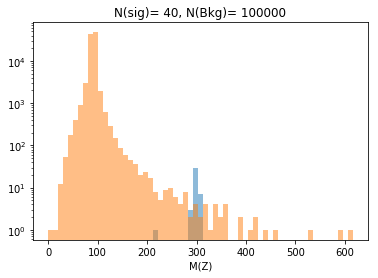

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 4.0)
(0.0, 8.0)
(3.0, 2.0)
(29.0, 4.0)
(7.0, 2.0)
(0.0, 4.0)
(0.0, 1.0)
(0.0, 4.0)
(0.0, 2.0)
N total signals: 
39.0
N total backgrounds: 
37.0
6.411560504908935
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


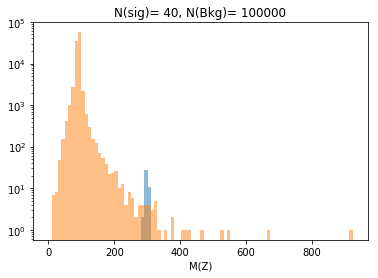

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 2.0)
(0.0, 4.0)
(2.0, 4.0)
(27.0, 4.0)
(11.0, 4.0)
(0.0, 3.0)
(0.0, 5.0)
(0.0, 1.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
33.0
6.963106238227914
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


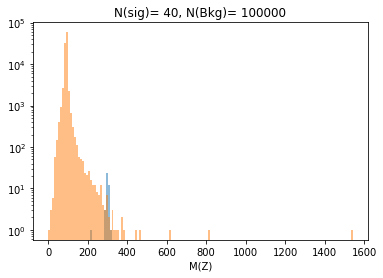

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 12.0)
(0.0, 4.0)
(3.0, 3.0)
(23.0, 7.0)
(12.0, 2.0)
(1.0, 1.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
41.0
6.090776713655637
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


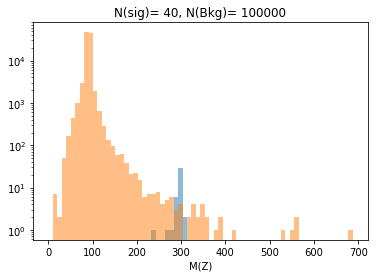

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(1.0, 5.0)
(1.0, 6.0)
(6.0, 3.0)
(29.0, 4.0)
(2.0, 0.0)
(0.0, 2.0)
(0.0, 4.0)
(0.0, 2.0)
(0.0, 4.0)
N total signals: 
39.0
N total backgrounds: 
34.0
6.688444820557844
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


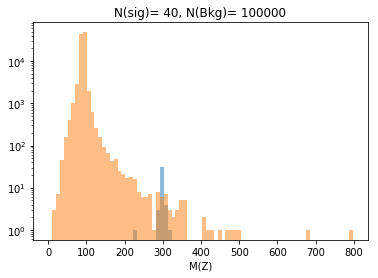

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 6.0)
(0.0, 7.0)
(0.0, 1.0)
(3.0, 8.0)
(31.0, 6.0)
(4.0, 7.0)
(1.0, 3.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 5.0)
N total signals: 
39.0
N total backgrounds: 
48.0
5.629165124598852
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


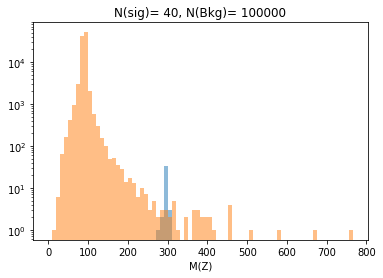

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 5.0)
(1.0, 2.0)
(2.0, 3.0)
(34.0, 3.0)
(3.0, 2.0)
(0.0, 5.0)
(0.0, 1.0)
(0.0, 0.0)
(0.0, 2.0)
N total signals: 
40.0
N total backgrounds: 
26.0
7.844645405527362
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


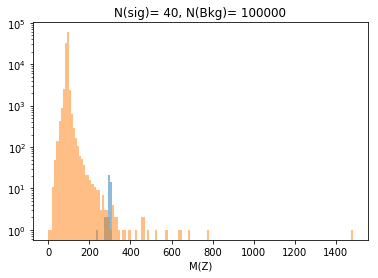

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 7.0)
(2.0, 3.0)
(2.0, 3.0)
(21.0, 2.0)
(14.0, 1.0)
(0.0, 4.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
28.0
7.370307223679931
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


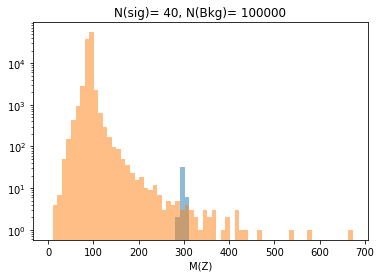

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 5.0)
(0.0, 4.0)
(2.0, 5.0)
(32.0, 3.0)
(6.0, 4.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 3.0)
N total signals: 
40.0
N total backgrounds: 
33.0
6.963106238227914
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


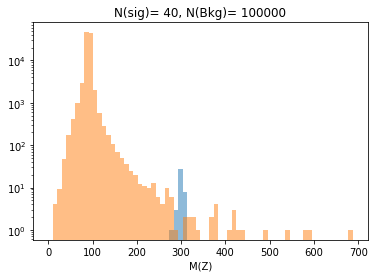

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 4.0)
(0.0, 10.0)
(1.0, 6.0)
(3.0, 1.0)
(28.0, 0.0)
(8.0, 2.0)
(0.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 0.0)
N total signals: 
40.0
N total backgrounds: 
28.0
7.559289460184544
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


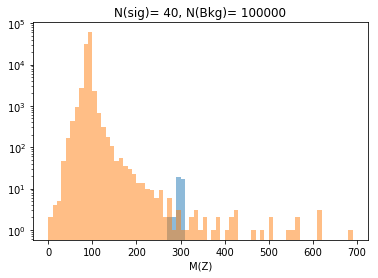

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 9.0)
(0.0, 2.0)
(2.0, 6.0)
(2.0, 1.0)
(19.0, 3.0)
(17.0, 1.0)
(0.0, 1.0)
(0.0, 2.0)
(0.0, 3.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
29.0
7.427813527082075
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


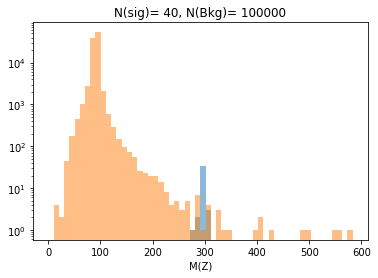

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 5.0)
(1.0, 1.0)
(2.0, 7.0)
(34.0, 1.0)
(3.0, 4.0)
(0.0, 0.0)
(0.0, 3.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
26.0
7.844645405527362
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


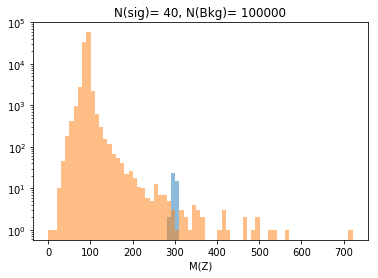

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 13.0)
(0.0, 7.0)
(0.0, 7.0)
(2.0, 5.0)
(23.0, 3.0)
(15.0, 1.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 4.0)
N total signals: 
40.0
N total backgrounds: 
46.0
5.897678246195885
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


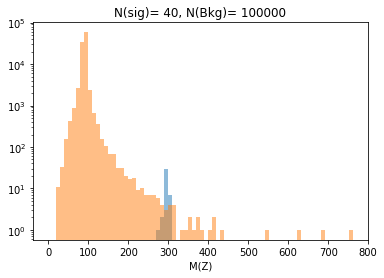

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 7.0)
(0.0, 7.0)
(1.0, 6.0)
(2.0, 4.0)
(30.0, 3.0)
(7.0, 4.0)
(0.0, 4.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
40.0
N total backgrounds: 
37.0
6.575959492214292
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


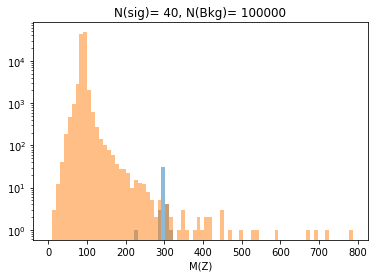

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 8.0)
(0.0, 5.0)
(0.0, 2.0)
(3.0, 5.0)
(31.0, 0.0)
(4.0, 4.0)
(1.0, 2.0)
(0.0, 0.0)
(0.0, 1.0)
(0.0, 3.0)
N total signals: 
39.0
N total backgrounds: 
30.0
7.12039324756716
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


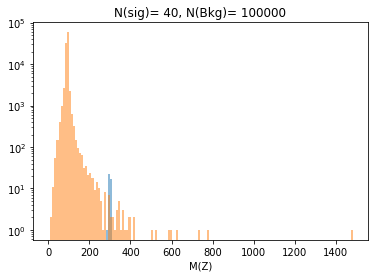

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 5.0)
(0.0, 1.0)
(0.0, 8.0)
(1.0, 0.0)
(22.0, 7.0)
(17.0, 2.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 3.0)
(0.0, 5.0)
N total signals: 
40.0
N total backgrounds: 
34.0
6.859943405700353
HLF_REF+BKG shape
(100000, 6)
HLF_SIG shape
(40, 6)


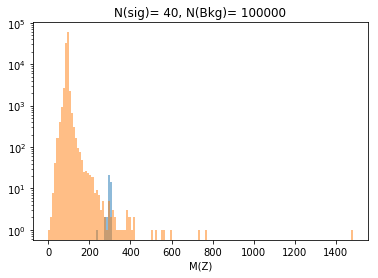

Figure saved
bin range [250-350] GeV
Nsig 	 Nbkg
(0.0, 3.0)
(0.0, 5.0)
(2.0, 2.0)
(2.0, 1.0)
(21.0, 5.0)
(14.0, 2.0)
(0.0, 3.0)
(0.0, 2.0)
(0.0, 1.0)
(0.0, 1.0)
N total signals: 
39.0
N total backgrounds: 
25.0
7.8
Mean sig 100: 7.018471508743999
Std sig 100: 0.6486761954992646
Err mean sig 100: 0.06486761954992645


In [27]:
N_Sig = 40
N_Bkg = 100000

repetitions=100
sign100=np.array([])
sign50=np.array([])
sign20=np.array([])

for i in range(repetitions):
    
    HLF_BKG, HLF_SIG = BuildSample(N_Sig, N_Bkg, 0, INPUT_PATH_BKG, INPUT_PATH_SIG)
    nbkg, nsig = Significance(HLF_BKG, HLF_SIG, N_Bkg=100000, N_Sig=40, Zprime_mass=300, toy_label=i)
    significance = nsig/np.sqrt(nbkg)
    sign100=np.append(sign100, significance)
    print(significance)
    '''
    nbkg, nsig = Significance(HLF_BKG, HLF_SIG, N_Bkg=100000, N_Sig=100, Zprime_mass=300, toy_label=i)
    significance = nsig/np.sqrt(nbkg)
    sign50=np.append(sign50, significance)
    print(significance)
    
    nbkg, nsig = Significance(HLF_BKG, HLF_SIG, N_Bkg=100000, N_Sig=80, Zprime_mass=300, toy_label=i)
    significance = nsig/np.sqrt(nbkg)
    sign20=np.append(sign20, significance)
    print(significance)
    '''
print('Mean sig 100: '+str(np.mean(sign100)))
print('Std sig 100: '+str(np.std(sign100)))
print('Err mean sig 100: '+str(np.std(sign100)/np.sqrt(repetitions)))



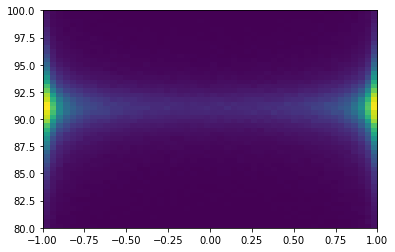

In [76]:
plt.hist2d(final_BKG[:, -1], final_BKG[:, -2], bins=[50,50], range=[[-1, 1],[80, 100]])
plt.show()

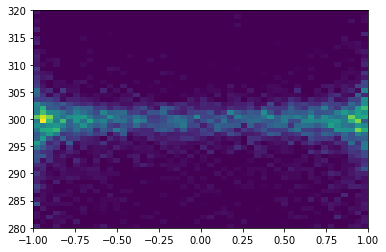

In [77]:
plt.hist2d(final_SIG[:, -1], final_SIG[:, -2], bins=[50,50], range=[[-1, 1],[280, 320]])
plt.show()

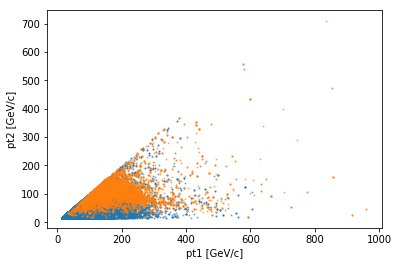

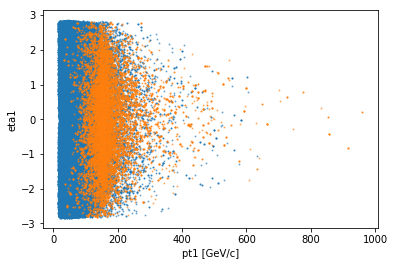

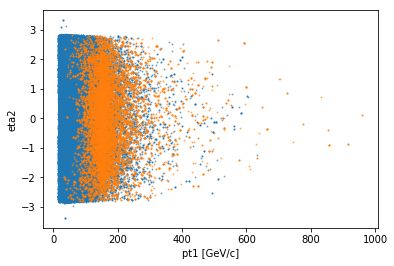

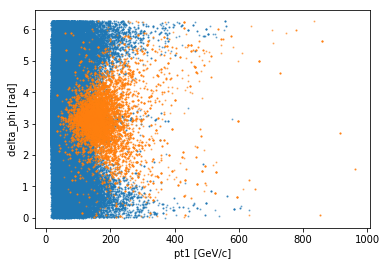

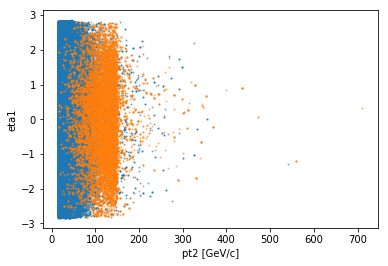

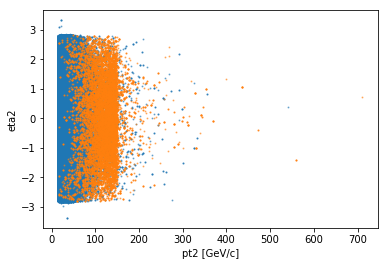

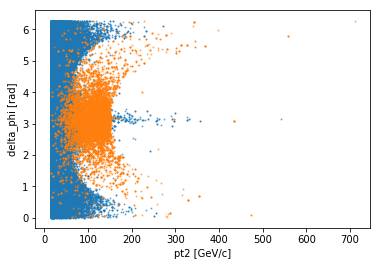

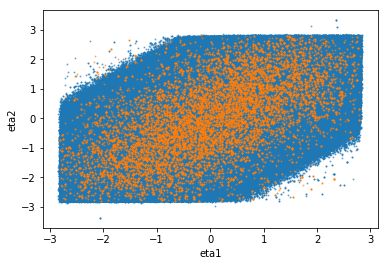

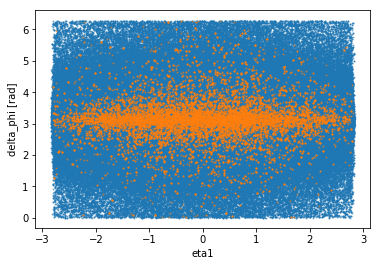

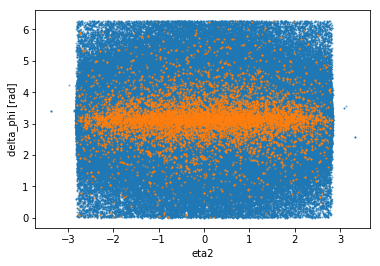

In [10]:
final_variables=['pt1 [GeV/c]', 'pt2 [GeV/c]', 'eta1', 'eta2', 'delta_phi [rad]', 'Z_mass [GeV]', 'cos_phi1 [rad]']
for i in range(final_features.shape[1]-2):
    for j in range(final_features.shape[1]-2):
        if j<=i:
            continue
        plt.scatter(final_BKG[:, i], final_BKG[:, j], label='Bkg only',
                   s=1, alpha=0.5)
        plt.scatter(final_SIG[:, i], final_SIG[:, j], label='Sig only', 
                   s=1, alpha=0.5)
        plt.xlabel(final_variables[i])
        plt.ylabel(final_variables[j])
        plt.show()

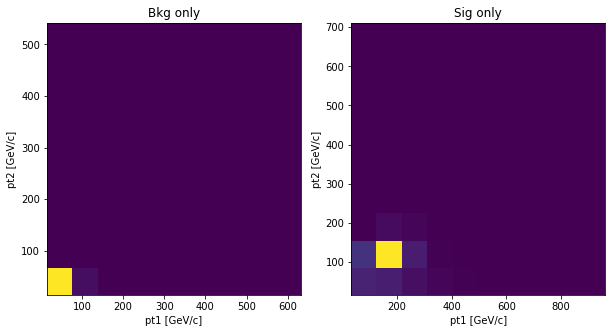

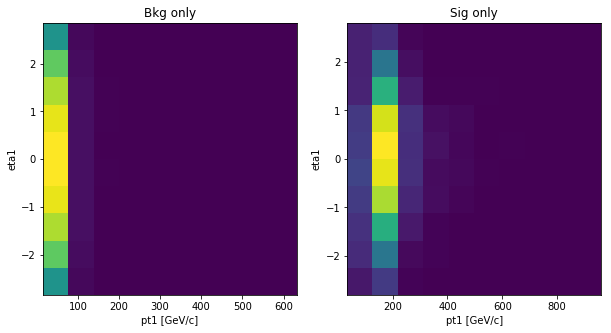

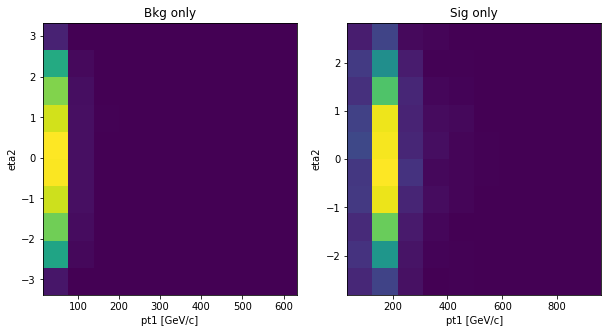

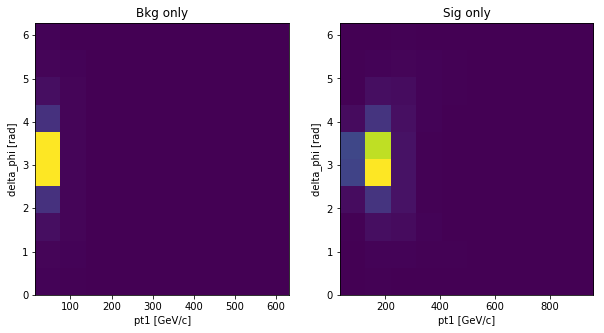

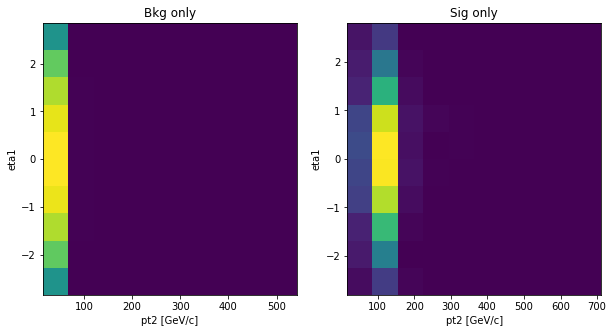

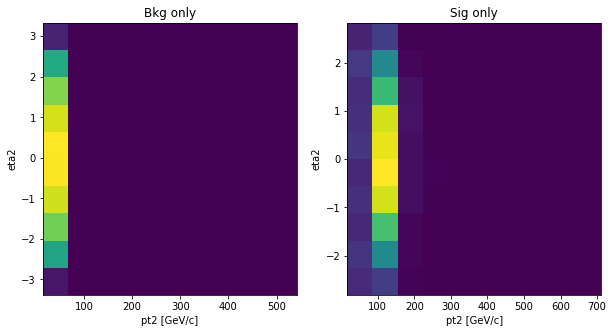

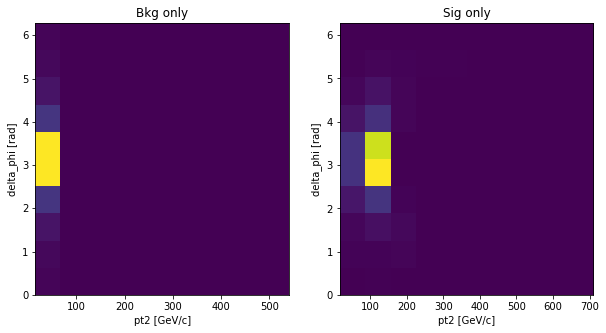

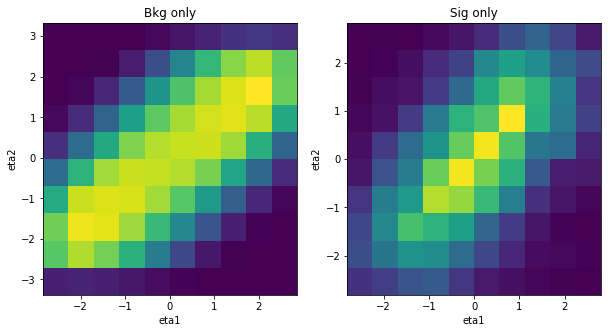

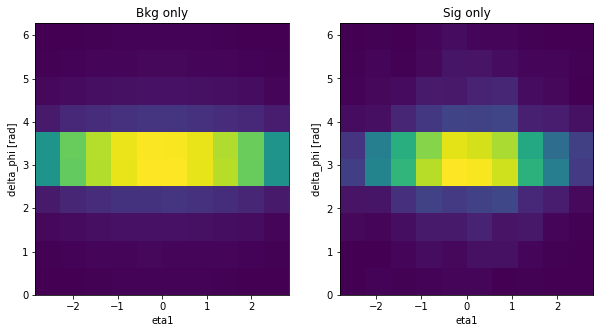

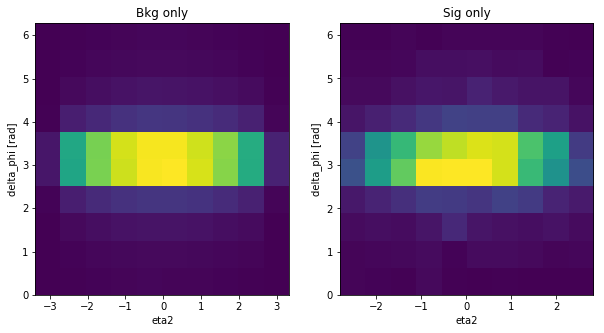

In [11]:
final_variables=['pt1 [GeV/c]', 'pt2 [GeV/c]', 'eta1', 'eta2', 'delta_phi [rad]', 'Z_mass [GeV]', 'cos_phi1 [rad]']
for i in range(final_features.shape[1]-2):
    for j in range(final_features.shape[1]-2):
        if j<=i:
            continue
        fig=plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.hist2d(final_BKG[:, i], final_BKG[:, j], label='Bkg only',
                   #s=1, alpha=0.5
                  )
        plt.xlabel(final_variables[i])
        plt.ylabel(final_variables[j])
        plt.title('Bkg only')
        plt.subplot(1, 2, 2)
        plt.hist2d(final_SIG[:, i], final_SIG[:, j], label='Sig only', 
                   #s=1, alpha=0.5
                  )
        plt.xlabel(final_variables[i])
        plt.ylabel(final_variables[j])
        plt.title('Sig only')
        plt.show()

## FIT

In [131]:
def FitFeature0(x, N, A, B, loc, scale):
    return -N*(x*x*1./B-A)*np.exp(-np.abs((x-loc)/scale))

def Exp(x, N, loc, scale):
    return N*np.exp(-(x-loc)/scale)

def CrystalBall(x, beta, m, loc, scale):
    """
    Return PDF of the crystalball function.
                                           | exp(-x**2 / 2),  for x > -beta
     crystalball.pdf(x, beta, m) =  N * |
                                           | A * (B - x)**(-m), for x <= -beta
    """
    y=np.array([])
    A = (m/beta)**m * np.exp(-beta**2 / 2.0)
    B = (m/beta) - beta 
    C = (m/beta) / (m-1) * np.exp(-beta**2 / 2.0)
    D = np.sqrt(np.pi*0.5) * 2*norm.cdf(beta/np.sqrt(2.))
    N = 1.0 /(scale*(C+D))
    return np.where((x-loc)/scale > -beta, N * np.exp(-((x-loc)/scale)*((x-loc)/scale) / 2.0), N * A *(B-((x-loc)/scale)**(-m)))

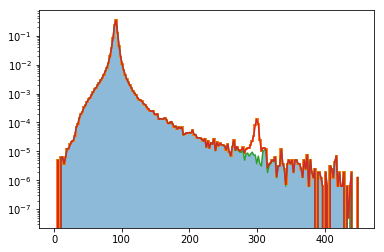

In [119]:
#bins=np.append(np.linspace(0, 400, 100), np.linspace(404, 2000, 5))
bins=np.linspace(0, 450, 200)
bkg_only = plt.hist(final_BKG[:, -2], bins=bins, weights=bkg_weights/Norm_Bkg, range=(np.min(final_features[:, -2]), np.max(final_features[:, -2])),
             alpha=0.5, label='Bkg only')
bkg_sig = plt.hist(final_features[:, -2], bins=bins, weights=merged_weights/(Norm_Sig+Norm_Bkg), range=(np.min(final_features[:, -2]), np.max(final_features[:, -2])),
             histtype='step', linewidth=2, label='Sig + Bkg')
plt.yscale('log')
x=np.array([])
xbins=bkg_only[1]
for i in range(bkg_only[1].shape[0]-1):
    x_i=0.5*(xbins[i+1]+xbins[i])
    x=np.append(x, x_i)
plt.semilogy(x, bkg_only[0])
plt.semilogy(x, bkg_sig[0])
plt.show()

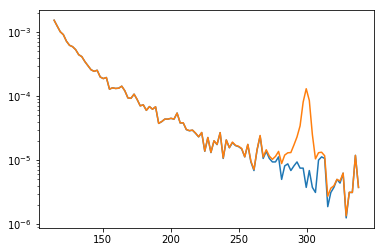

In [125]:
plt.semilogy(x[50:150], bkg_only[0][50:150])
plt.semilogy(x[50:150], bkg_sig[0][50:150])
plt.show()

In [133]:
fitfunc = lambda p, x: Exp(x, p[0], p[1], p[2])
errfunc = lambda p, x, y: (y - fitfunc(p, x))
init = (1, 0, 1)
out = least_squares( errfunc, init, args=(x[50:150], bkg_only[0][50:150]))
print(out.x)

[1. 0. 1.]


In [102]:
#plt.hist(data, bins=100, density=True, range=(np.percentile(data, 5), np.percentile(data, 95)))
#plt.hist(ref, weights=target[target!=1], bins=100, range=(np.percentile(data, 10), np.percentile(data, 90)), density=True)
plt.plot(x, fitfunc(out.x, x))
plt.title('Recostruction')
plt.show()


plt.plot(errfunc(out.x, x, h[0]))
plt.title('Error function')
plt.show()

205.70254271460158

In [24]:
import ROOT
from rootpy.plotting import Canvas, histogram
from ROOT import TMath
from rootpy.plotting import Hist, HistStack, Legend, Canvas
from rootpy.plotting.style import get_style, set_style
from rootpy.plotting.utils import draw
from rootpy.interactive import wait
import rootpy.plotting.root2matplotlib as rplt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator

 FCN=95.802 FROM MIGRAD    STATUS=CONVERGED     342 CALLS         343 TOTAL
                     EDM=2.56048e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.98403e+03   5.66487e+02   3.47969e-01  -5.44230e-07
   2  p1           1.43314e+02   3.02367e+00   2.45512e-03  -4.83323e-05
   3  p2           1.03104e+01   3.51963e-01   5.78986e-04  -4.09461e-04


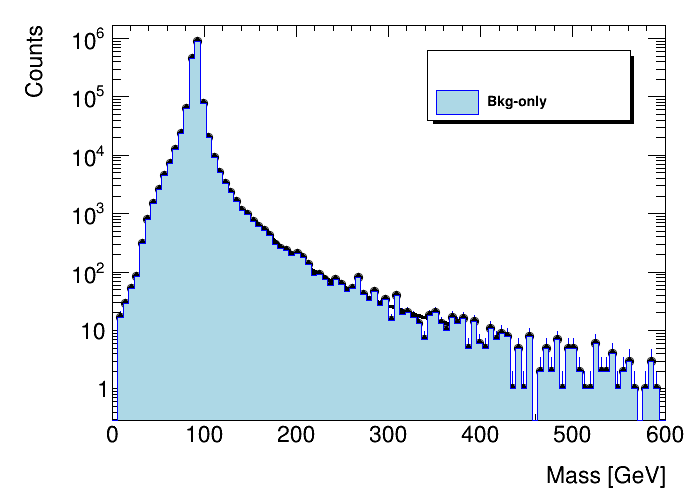

In [65]:
def landau():
    return "[0]*TMath::Landau(x,[1],[2])"

bkg_line=ROOT.TF1("Bkg_fit", landau(), 260, 320)
bkg_line.SetParameters(1, 300, 1, 1, 280, 1.0)

c1 = Canvas()
bins, h1 = histogram(final_BKG[:, -2], 100, 0, 600, title='Bkg-only',
                     drawstyle='hist', legendstyle='F')

h1.DrawCopy()
h1.Fit('Bkg_fit','S', '', 150, 380)
#bkg_line.linewidth=3
#bkg_line.linecolor='red'
#bkg_line.Draw('SAME')
h1.fillstyle = 'solid'
h1.fillcolor = 'lightblue'
h1.linecolor = 'blue'
h1.linewidth = 1
h1.DrawCopy('SAME')
c1.SetLogy()
h1.GetXaxis().SetTitle("Mass [GeV]") # set x-axis title
h1.GetYaxis().SetTitle("Counts") # set y-axis title
# set visual attributes

# create the legend
legend = Legend([h1], pad=c1,
                header='',
                leftmargin=0.45,
                rightmargin=0.05
               )
legend.SetTextSize(0.03)
legend.Draw()

c1.Update()
c1.Draw('SAME')



 FCN=95.802 FROM MIGRAD    STATUS=CONVERGED     342 CALLS         343 TOTAL
                     EDM=2.56048e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           4.98403e+03   5.66487e+02   3.47969e-01  -5.44230e-07
   2  p1           1.43314e+02   3.02367e+00   2.45512e-03  -4.83323e-05
   3  p2           1.03104e+01   3.51963e-01   5.78986e-04  -4.09461e-04


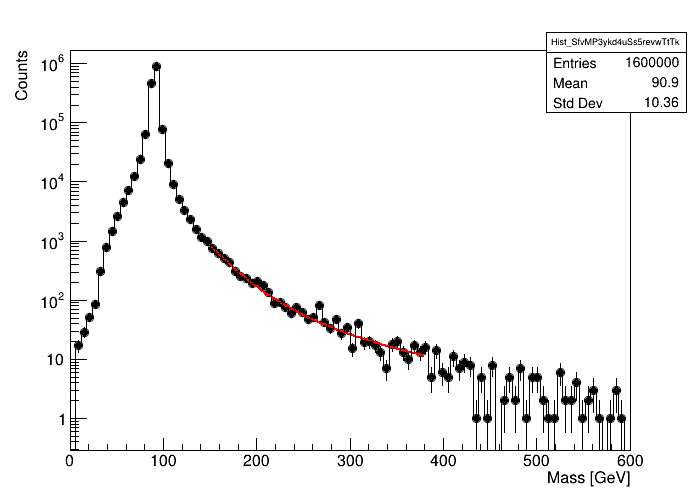

In [22]:
ROOT.gStyle.SetOptStat(1)
c1 = Canvas()
bins, h1 = histogram(final_BKG[:, -2], 100, 0, 600, drawstyle='hist')
h1.DrawCopy()
h1.Fit('Bkg_fit','S', '', 150, 380)
h1.DrawCopy('SAME')
c1.SetLogy()
h1.GetXaxis().SetTitle("Mass [GeV]") # set x-axis title
h1.GetYaxis().SetTitle("Counts") # set y-axis title
c1.Update()
c1.Draw('SAME')

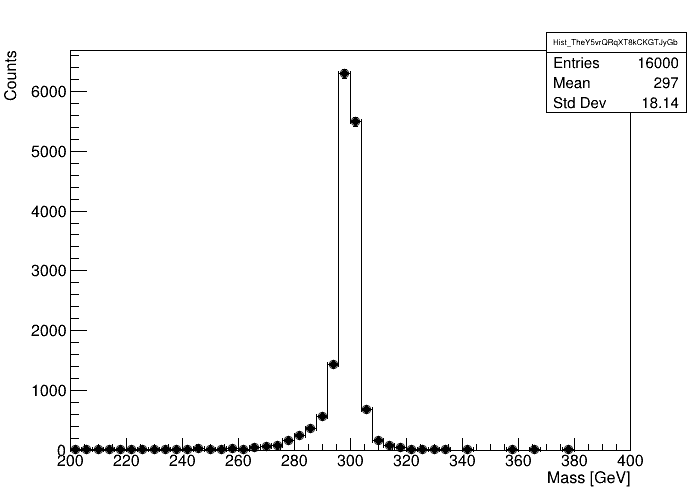

In [300]:
ROOT.gStyle.SetOptStat(1)
c2 = Canvas()

#c1.SetLogy()
bins, h2 = histogram(final_SIG[:, -2], 50, 200, 400, drawstyle='hist')
h2.GetXaxis().SetTitle("Mass [GeV]") # set x-axis title
h2.GetYaxis().SetTitle("Counts") # set y-axis title
h2.Draw('E1')
c2.Draw('AP')

In [301]:
def gausgaus():
    return "[0]*exp(-((x-[1])/[2])**2) + [3]*exp(-((x-[4])/[5])**2) "#"+ [4]*exp(-(x/[5])**2)"

     
sig_line=ROOT.TF1("sig_fit", gausgaus(), 260, 320)
sig_line.SetParameters(1, 300, 1, 1, 280, 1.0)


 FCN=93.4762 FROM MIGRAD    STATUS=CONVERGED     162 CALLS         163 TOTAL
                     EDM=2.09986e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           7.15783e+03   8.55953e+01   3.24296e-01  -4.82473e-06
   2  p1           2.99669e+02   2.99221e-02   1.42893e-04   8.38750e-03
   3  p2           3.87160e+00   3.95361e-02   1.22062e-04  -3.61347e-03
   4  p3           5.34806e+02   2.32541e+01   5.62244e-02   1.79863e-05
   5  p4           2.93604e+02   2.52109e-01   9.10018e-04  -2.13228e-03
   6  p5          -1.41155e+01   2.44209e-01   7.27589e-04   7.88798e-05


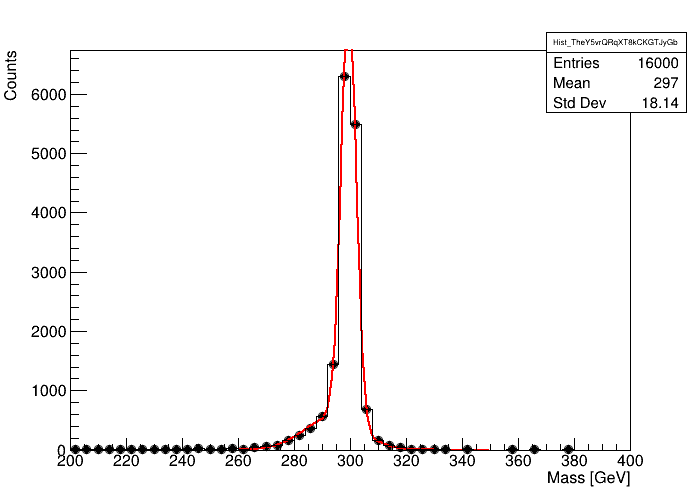

In [366]:
h2.DrawCopy()
h2.Fit('sig_fit','S', '', 260, 350)
h2.DrawCopy('SAME')
#c1.SetLogy()
c2.Update()
h2.GetXaxis().SetTitle("Mass [GeV]") # set x-axis title
h2.GetYaxis().SetTitle("Counts") # set y-axis title
c2.Draw()

In [367]:
sig_line.GetParameter(0)
bkg_line.GetParameter(0)

4457.235388918833

INFO:ROOT.TCanvas.Print] png file /tmp/tmpnFvZAt.png has been created


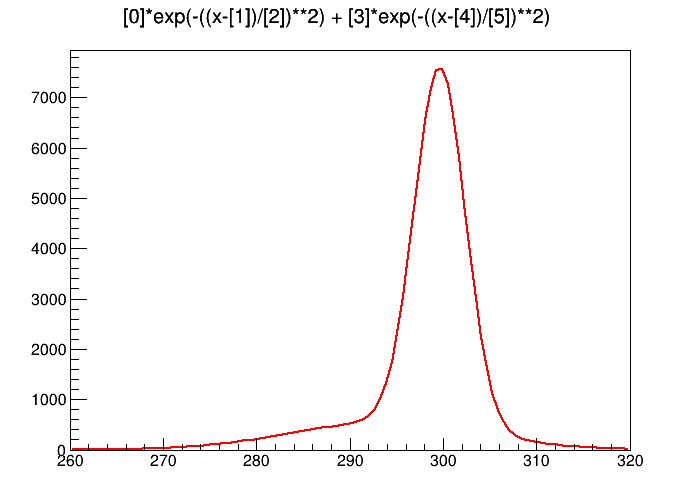

In [368]:
sig_line

INFO:ROOT.TCanvas.Print] png file /tmp/tmp9yEoZJ.png has been created


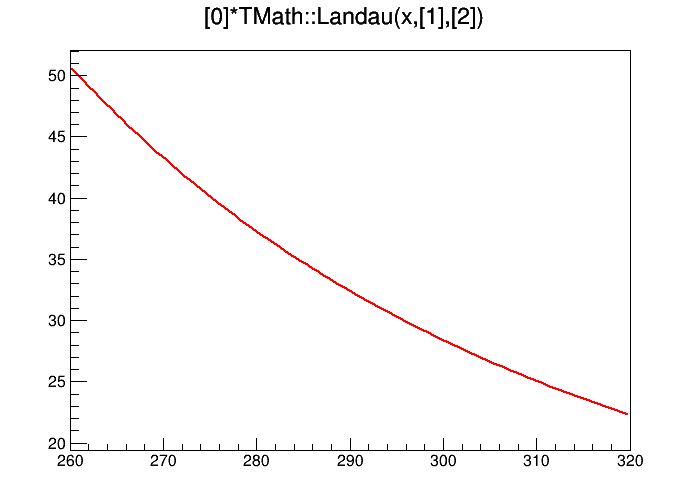

In [369]:
bkg_line

In [370]:
def sig_bkg_probability():
    return "40./16000*([0]*exp(-((x-[1])/[2])**2) + [3]*exp(-((x-[4])/[5])**2)) + 100000./1600000*[6]*TMath::Landau(x,[7],[8])"

In [371]:
sig_bkg_line=ROOT.TF1("sig_bkg_fit", sig_bkg_probability(), 200, 350)

In [372]:
sig_bkg_line.SetParameters(sig_line.GetParameter(0), sig_line.GetParameter(1), sig_line.GetParameter(2), sig_line.GetParameter(3), 
                           sig_line.GetParameter(4), sig_line.GetParameter(5), bkg_line.GetParameter(0), bkg_line.GetParameter(1),
                           bkg_line.GetParameter(2)#, Norm_Sig, Nsig, Norm_Bkg, Nbkg
                          )

INFO:ROOT.TCanvas.Print] png file /tmp/tmprsLeY0.png has been created


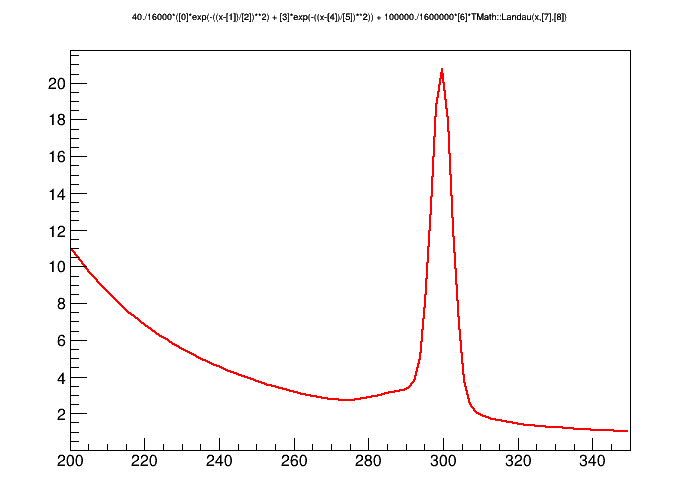

In [373]:
sig_bkg_line

In [374]:
def log_ratio():
    return "log(40./16000*([0]*exp(-((x-[1])/[2])**2) + [3]*exp(-((x-[4])/[5])**2))/(100000*[6]*TMath::Landau(x,[7],[8])/1600000) + 1)"

In [375]:
log_ratio_line=ROOT.TF1("sig_bkg_fit", log_ratio(), 260, 350)

In [376]:
log_ratio_line.SetParameters(sig_line.GetParameter(0), sig_line.GetParameter(1), sig_line.GetParameter(2), sig_line.GetParameter(3), 
                           sig_line.GetParameter(4), sig_line.GetParameter(5), bkg_line.GetParameter(0), bkg_line.GetParameter(1),
                           bkg_line.GetParameter(2)#, Norm_Sig, Nsig, Norm_Bkg, Nbkg
                          )

INFO:ROOT.TCanvas.Print] png file /tmp/tmpwd8P2J.png has been created


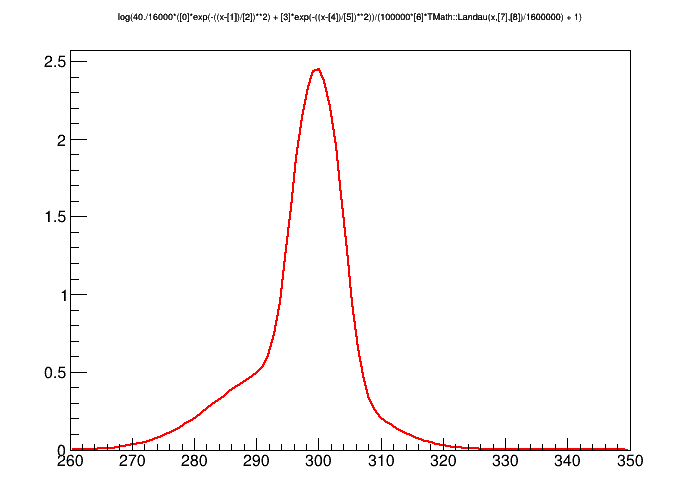

In [377]:
c3 = Canvas()
log_ratio_line
log_ratio_line.GetXaxis().SetTitle("Mass [GeV]") # set x-axis title
log_ratio_line.GetYaxis().SetTitle("Counts") # set y-axis title
c3.Draw()

In [378]:
integr=log_ratio_line.Integral(260, 320)

In [384]:
sigma=np.sqrt(2*(40-integr))

In [385]:
integr

32.02756905728028

In [386]:
sigma

3.99310178751299

In [383]:
np.sqrt(2*integr)

8.003445390240415